**Professor:** Enrique Garcia Ceja
**email:** enrique.gc@tec.mx

Ariel López García    A01275913

# Removing masks from profile pictures using a convolutional autoenconder.

We are going to build an autoencoder to perform a denoising operation, specifically, removing mask filters from pictures.

<img src="https://github.com/enriquegit/ap-img/blob/main/img/unmask.png?raw=true" width="600">

We will use a dataset from Tinder profile pictures. A python script was used to apply a dog filter to the pictures. In a previous work, the authors used Generative Adversarial Networks (GANs) to denoise the pictures. [Here](https://github.com/ipsingh06/ml-desnapify) you can find the original code to apply the filters and solve the problem using GANs.

Based on training data, the autoencoder will try to 'imagine' what is under the mask and it will try to recreate the original face without filters.

### Instructions to upload dataset

**Note: Before uploading the dataset make sure you have selected the GPU runtime!**

1. Create a folder named "datasets" in the current working directory (same level as the "sample_data" directory).

2. Upload the *sample_faces.zip* (provided by the professor) file in the newely created "datasets" directory. It may take some minutes.

3. Run the following cell to unzip the files.

In [ ]:
# This cell is used to unzip the faces dataset.
import zipfile

with zipfile.ZipFile("datasets/sample_faces.zip", 'r') as zip_ref:
    zip_ref.extractall("datasets/")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

In [ ]:
# Specify the parent path where the the 'masked' and 'original' pictures are.

rootpath = "datasets/"

In [ ]:
files_original = os.listdir(rootpath + "original/")

files_mask = os.listdir(rootpath + "masked/")

n = 2500 # Number of images to process.

target_size = (200,200) # Image size. For computational reasons, resize the images to 200x200

imgs_original = [] # Original images are stored here.

imgs_mask = [] # Images with mask are stored here.

for i in range(n):
    img = image.load_img(rootpath + "original/" + files_original[i], target_size=target_size)
    img = image.img_to_array(img)
    img = img/255.
    imgs_original.append(img)

    img2 = image.load_img(rootpath + "masked/" + files_mask[i], target_size=target_size)
    img2 = image.img_to_array(img2)
    img2 = img2/255.
    imgs_mask.append(img2)

imgs_original=np.array(imgs_original)

imgs_mask=np.array(imgs_mask)

# shuffle images
n = imgs_original.shape[0]
np.random.seed(123)
idxs = np.random.choice(n, size=n, replace=False)
imgs_original = imgs_original[idxs,:,:,:]
imgs_mask = imgs_mask[idxs,:,:,:]

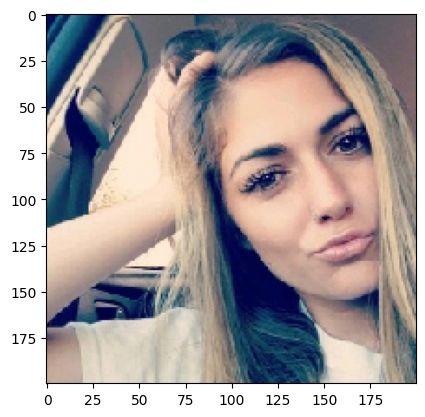

In [ ]:
selected = 19 # Select an image to display.

plt.imshow(imgs_original[selected,])

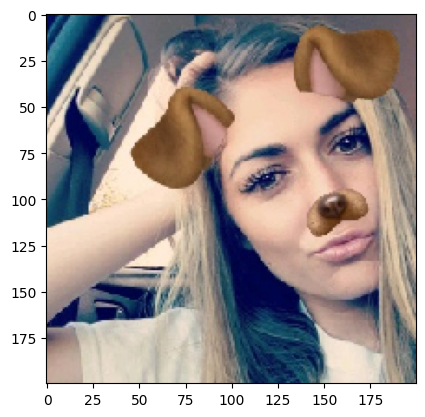

In [ ]:
# Display same image but with filter applied.

plt.imshow(imgs_mask[selected,])

In [ ]:
# Select some test images.

n_test = 100 # number of images to use as test set

# This is the training set.
train_orig = imgs_original[n_test:,:,:,:]
train_mask = imgs_mask[n_test:,:,:,:]

# This is the test set.
test_orig = imgs_original[0:n_test,:,:,:]
test_mask = imgs_mask[0:n_test,:,:,:]

`train_orig` and `train_mask` contain the train set images with and without masks.

`test_orig` and `test_mask` contain the test set images with and without masks.


### Now, it is time to define the convolutional autoencoder. Since the purpose of this model is not to compress data but to denoise, it is not necessary for the 'middle layer' to be very small.

In [ ]:
# Define your convolutional autoencoder and name it 'autoencoder'.
# YOUR CODE HERE.

input_img = Input(shape=(200, 200, 3))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='leaky_relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

###Se ha intentado con silu, leaky_relu, relu, tanh, linear, swish combinaciones de estas mismas y de los mejores resultados ha sido relu y silu individualmente

###De igual manera se utilizaron 64 neuronas, posteriormente 32 y 16 usando reciprocamente en las neuronas de reescalamiento

# This time we will use the Adam optimizer instead of SGD
# which uses momentum.
opt = optimizers.Adam()

# Compile the model.
autoencoder.compile(optimizer=opt, loss='binary_crossentropy')

# Print a summary of the model.
print(autoencoder.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 200, 200, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 200, 200, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 100, 100, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 50, 50, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 25, 25, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_24 (UpSampling2D)      │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 50, 50, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_25 (UpSampling2D)      │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_26 (UpSampling2D)      │ (None, 200, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 200, 200, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 68,227 (266.51 KB)

 Trainable params: 68,227 (266.51 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the autoencoder with the fit function. The inputs are the images with mask and the predicted images
# are the ones without masks.
# YOUR CODE HERE.

autoencoder.fit(train_mask, train_orig,
                epochs=70,  #Lo habíamos hecho con 100 épocas en cada intento
                batch_size=16,
                shuffle=True,
                validation_split=0.15)

### Se hizo mediante CPU y GPu de colab para ver si había mejoras en la rapidez

Epoch 1/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.4957 - val_loss: 0.4880
Epoch 2/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.4965 - val_loss: 0.4872
Epoch 3/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.4987 - val_loss: 0.4866
Epoch 4/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.4940 - val_loss: 0.4888
Epoch 5/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.4938 - val_loss: 0.4864
Epoch 6/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.4951 - val_loss: 0.4863
Epoch 7/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.4946 - val_loss: 0.4861
Epoch 8/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.4981 - val_loss: 0.4863
Epoch 9/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 0.4936 - val_loss: 0.4895
Epoch 10/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.4944 - val_loss: 0.4866
Epoch 11/70
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.4962 - val_loss: 0.4862
Epoch 12/70
128/128 ━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


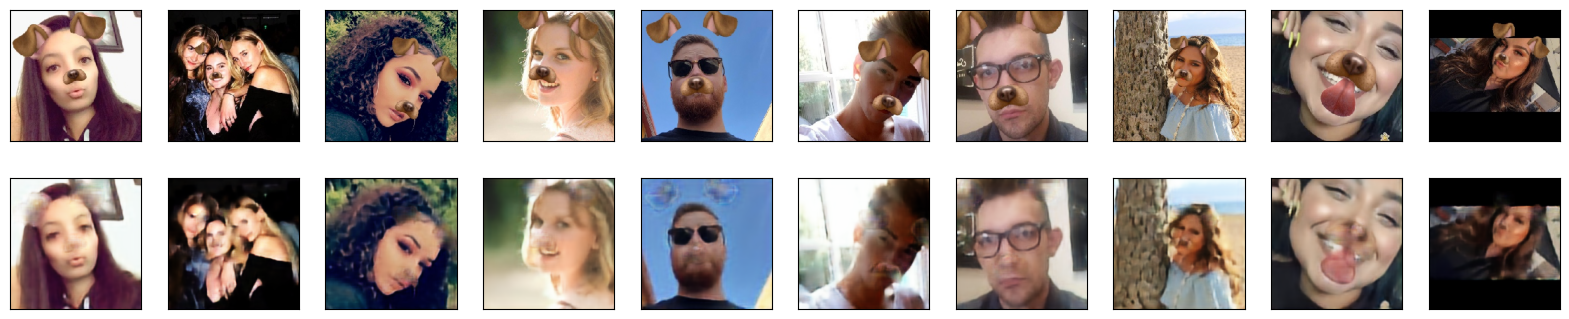

In [ ]:
# Let's display the masked images (first n) and the predicted denoised images (bottom).

# Number of images to display from training set
n = 10

decoded_imgs = autoencoder.predict(train_mask[1:n+1,])

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_mask[i+1].reshape(train_orig.shape[1], train_orig.shape[2], train_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(train_orig.shape[1], train_orig.shape[2], train_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


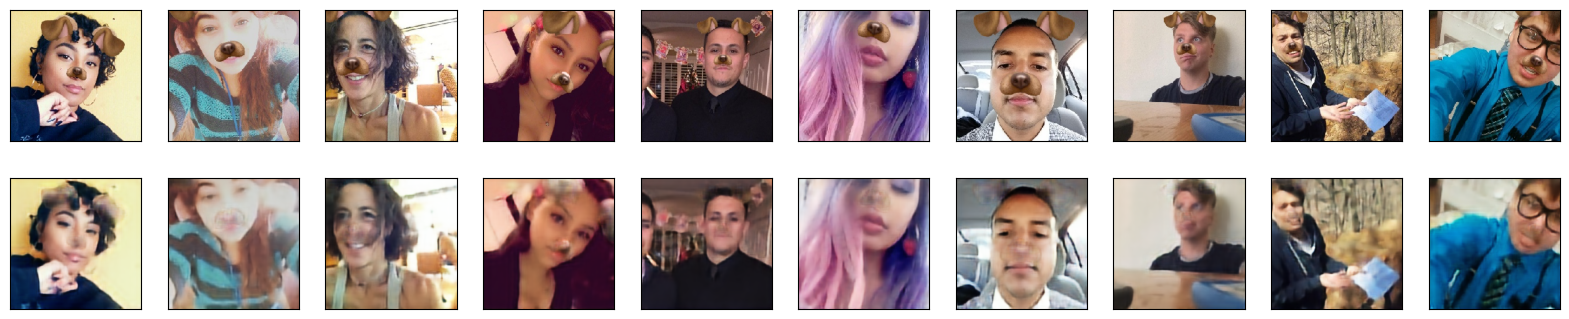

In [ ]:
# Now lets try the autoencoder on the test set!

startpos = 0 # start position. Try different start positions: 10, 20, 30, etc.

n = 10 # # number of images to show begining at startpos.

decoded_imgs = autoencoder.predict(test_mask[startpos:startpos+n,])

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_mask[i+startpos].reshape(test_orig.shape[1], test_orig.shape[2], test_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(test_orig.shape[1], test_orig.shape[2], test_orig.shape[3]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()